# Ideal Gas Model with Histograms

Suppose we want to graph a histogram of the speeds of atoms in the ideal gas simulation.

Let's start with our simulation.

## Ideal Gas Model

In [1]:
from vpython import *
import numpy as np
import random as rand
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>

In [2]:
def check_collisions():
    """Determine all pairs of colliding spheres in the global particles[] list. 
        
    """
    collided_pairs = [] #a list of pairs of spheres that are overlapping
    
    for i in range(N):
        for j in range(i+1,N): #start at i+1 to avoid double counting and to avoid self-collision
            d = mag(particles[i].pos - particles[j].pos)
            if d < 2*R:
                collided_pairs.append([i,j])            
    
    return collided_pairs

In [3]:
def calc_collision(i,j):
    """Calculate new velocity, momentum, and position of pairs of colliding spheres in the global particles[] list. 

    Keyword arguments:
    i -- index of one colliding sphere
    j -- index of second colliding sphere

    """

    global particles
    
    r1 = particles[i].pos
    r2 = particles[j].pos
    v1 = particles[i].v
    v2 = particles[j].v
    p1 = m*v1
    p2 = m*v2
    v1i = v1
    v2i = v2
    
    #transform to reference frame of particle 1
    v2rel = v2 - v1
    r2rel = r2 - r1
    
    #find time when collision ocurred
    dx = dot(r2rel, hat(v2rel))
    dy = mag(cross(r2rel, hat(v2rel)))
    alpha = asin(dy/2/R)
    d = 2*R*cos(alpha) + dx
    deltat = d/mag(v2rel)
    
    #move particles backward in time to their locations at the collision
    particles[i].pos = particles[i].pos - particles[i].v*deltat
    particles[j].pos = particles[j].pos - particles[j].v*deltat
    
    #calculate new momenta using CM reference frame
    r1 = particles[i].pos
    r2 = particles[j].pos
    M = 2*m #total mass
    ptot = p1+p2 #total momentum
    vcm = ptot/M
    v1rel = v1 - vcm
    v2rel = v2 - vcm
    p1rel = m*v1rel
    p2rel = m*v2rel
    r = r2 - r1
    p1rel = p1rel - 2*dot(p1rel,hat(r))*hat(r)
    p2rel = p2rel - 2*dot(p2rel,hat(r))*hat(r)
    v1rel = p1rel/m
    v2rel = p2rel/m
    v1 = vcm + v1rel
    v2 = vcm + v2rel
    p1 = m*v1
    p2 = m*v2
    particles[i].v = v1
    particles[j].v = v2

    #move particles forward in time to their locations at the end of the time step
    particles[i].pos = particles[i].pos + particles[i].v*deltat
    particles[j].pos = particles[j].pos + particles[j].v*deltat
    


In [7]:
scene = canvas(title="N Particles in a Box")

#constants
m = 1.7e-27 #mass of atom in kg
R = 0.5e-10 #radius of atom in m
L = 40*R #length of box in m
thick = L/100 #thickness of box wall in m
k = 1.4e-23 #boltzmann constant
T = 300 #temp in K
s =  np.sqrt(2*3/2*k*T/m) #initial speed

#visual objects
Lwall = box(pos = vec(-L/2, 0, 0), size = vec(thick, L, L), color=color.white)
Rwall = box(pos = vec(L/2, 0, 0), size = vec(thick, L, L), color=color.white)
Bwall = box(pos = vec(0, -L/2, 0), size = vec(L, thick, L), color=color.white)
Twall = box(pos = vec(0, L/2, 0), size = vec(L, thick, L), color=color.white)
Zwall = box(pos = vec(0, 0, -L/2), size = vec(L, L, thick), color=color.white)

particles = [] #list of particles

N=100 #number of particles

#create particles
for i in range(N):
    if i==0:
        particle = sphere(pos = L/2*vec(rand.uniform(-0.9,0.9),rand.uniform(-0.9,0.9),rand.uniform(-0.9,0.9)), radius = R, color = color.cyan, make_trail=True, retain=20, trail_radius=0.3*R)
    else:
        particle = sphere(pos = L/2*vec(rand.uniform(-0.9,0.9),rand.uniform(-0.9,0.9),rand.uniform(-0.9,0.9)), radius = R, color = color.red)

    #initial velocity
    particle.v = s*hat(vec(rand.uniform(-1,1), rand.uniform(-1,1), rand.uniform(-1,1)))
    particle.p = m*particle.v

    particles.append(particle)

#check for collisions and rerandomize positions of particles that are collided
collided_pairs = check_collisions()
while len(collided_pairs)!=0:
    for pair in collided_pairs:
        particles[pair[0]].pos = L/2*vec(rand.uniform(-1,1),rand.uniform(-1,1),rand.uniform(-1,1))
        particles[pair[1]].pos = L/2*vec(rand.uniform(-1,1),rand.uniform(-1,1),rand.uniform(-1,1))
    collided_pairs = check_collisions()

#time
t = 0
dt = R/s/10

#evolution
scene.pause()

Nsteps = 1e4 #number of time steps for the loop
while t < Nsteps*dt:
    rate(1000) #sets number of loops per second in order to slow down or speed up visualization

    #update position of each particle
    for particle in particles:
        particle.pos = particle.pos + particle.v*dt
        
    #handle collisions of particles with each other
    collided_pairs = check_collisions()
    for pair in collided_pairs:
        i = pair[0]
        j = pair[1]
        calc_collision(i,j)
    
    #handle collision with walls
    for particle in particles:
        if particle.pos.x > L/2:
            particle.v.x = - abs(particle.v.x)
            particle.p = m*particle.v
        elif particle.pos.x < -L/2:
            particle.v.x = abs(particle.v.x)
            particle.p = m*particle.v

        if particle.pos.y > L/2:
            particle.v.y = - abs(particle.v.y)
            particle.p = m*particle.v
        elif particle.pos.y < -L/2:
            particle.v.y = abs(particle.v.y)
            particle.p = m*particle.v

        if particle.pos.z > L/2:
            particle.v.z = - abs(particle.v.z)
            particle.p = m*particle.v
        elif particle.pos.z < -L/2:
            particle.v.z = abs(particle.v.z)
            particle.p = m*particle.v

    t = t + dt


<IPython.core.display.Javascript object>

## Plot Histogram

To plot a histogram, you need to create "bins" for the speed of a particle and count the number of particles that have a speed that fall within that bin. Numpy can do that for you. The syntax is 


```python
hist, bin_edges = numpy.histogram(arr, bins=N)
```

where $N$ is the number of bins you want and $arr$ is the array or list of data. In our case we want to determine the precise bins (left edges of bins) for numpy to use in counting the data. To calculate the left edges of bins and use them in the histogram function, use

```python
#histogram stuff
deltav = 100 # binning for v histogram
nbins = int(6000/deltav) #number of bins
bin_edges = [int(i*deltav) for i in range(nbins)] #left side of bins

#store histogram
counts, binx = np.histogram([mag(particle.v) for particle in particles], bins=bin_edges)

```

If we do this after running our simulation, then we will have the final histogram. If we do it before our simulation we will have the initial histogram, where all particles have the same speed. This is a good way to see that it works.

To plot the histogram, create a bar graph with each bar at the center of the bin.

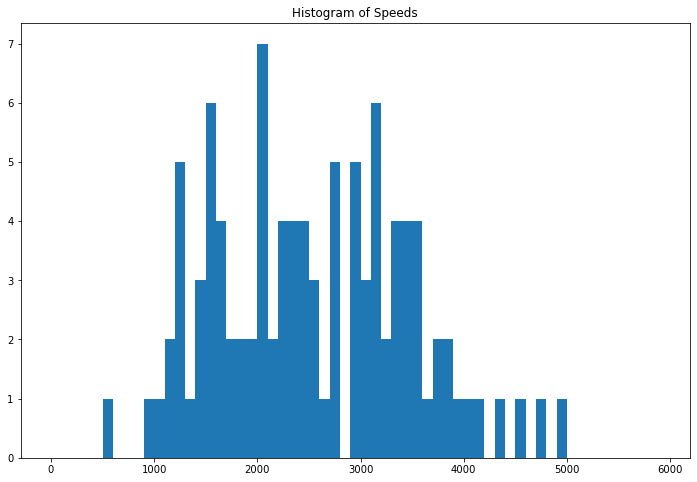

In [8]:
#histogram stuff
deltav = 100 # bin width for v histogram
nbins = int(6000/deltav) #number of bins
bin_edges = [int(i*deltav) for i in range(nbins)] #left side of bins

#store histogram
counts, binx = np.histogram([mag(particle.v) for particle in particles], bins=bin_edges, range=None, normed=None, weights=None, density=None)

#create histogram
#calculate speed at center of each bin
centers = [] #store speed at center of each bin
for i in range(len(binx)-1):
    vmiddle = (binx[i] + binx[i+1])/2 #calculate speed at center of bin
    centers.append(vmiddle)

#plot bar graph (histogram)
plt.figure(figsize=(12,8))
plt.bar(centers, counts, align='center', width=deltav)
plt.title('Histogram of Speeds')
plt.show()

Theoretically, the distribution should follow the Maxwell-Boltzmann distribution. Since the number of particles is relatively small, it is best to get a histogram after each time step and then average all of the histograms. In the code above the `histgram()` function returns `counts` which is an array of counts, which are integers correspoinding to the number of particles in each bin. A numpy array is different from a python list in that mathematical functions (and other functions) can operate on a numpy array. Thus, you can put a numpy array into a mathematical statement.

In our case, we will compute the histogram and store `counts` in a list. Then we will calculate the sum of the `counts` arrays in the list and divide by the number of arrays. This will give us the average count in each bin.

In the program below, we store a histogram at $t=0$ and after each time step in a list.

In [9]:
scene = canvas(title="N Particles in a Box")

#constants
m = 1.7e-27 #mass of atom in kg
R = 0.5e-10 #radius of atom in m
L = 40*R #length of box in m
thick = L/100 #thickness of box wall in m
k = 1.4e-23 #boltzmann constant
T = 300 #temp in K
s =  np.sqrt(2*3/2*k*T/m) #initial speed

#visual objects
Lwall = box(pos = vec(-L/2, 0, 0), size = vec(thick, L, L), color=color.white)
Rwall = box(pos = vec(L/2, 0, 0), size = vec(thick, L, L), color=color.white)
Bwall = box(pos = vec(0, -L/2, 0), size = vec(L, thick, L), color=color.white)
Twall = box(pos = vec(0, L/2, 0), size = vec(L, thick, L), color=color.white)
Zwall = box(pos = vec(0, 0, -L/2), size = vec(L, L, thick), color=color.white)

particles = [] #list of particles

N=100 #number of particles

#create particles
for i in range(N):
    if i==0:
        particle = sphere(pos = L/2*vec(rand.uniform(-0.9,0.9),rand.uniform(-0.9,0.9),rand.uniform(-0.9,0.9)), radius = R, color = color.cyan, make_trail=True, retain=20, trail_radius=0.3*R)
    else:
        particle = sphere(pos = L/2*vec(rand.uniform(-0.9,0.9),rand.uniform(-0.9,0.9),rand.uniform(-0.9,0.9)), radius = R, color = color.red)

    #initial velocity
    particle.v = s*hat(vec(rand.uniform(-1,1), rand.uniform(-1,1), rand.uniform(-1,1)))
    particle.p = m*particle.v

    particles.append(particle)

#check for collisions and rerandomize positions of particles that are collided
collided_pairs = check_collisions()
while len(collided_pairs)!=0:
    for pair in collided_pairs:
        particles[pair[0]].pos = L/2*vec(rand.uniform(-1,1),rand.uniform(-1,1),rand.uniform(-1,1))
        particles[pair[1]].pos = L/2*vec(rand.uniform(-1,1),rand.uniform(-1,1),rand.uniform(-1,1))
    collided_pairs = check_collisions()

#time
t = 0
dt = R/s/10

#histogram stuff
histograms = [] #a list of histograms after each time step
deltav = 100 # bin width for v histogram
nbins = int(6000/deltav) #number of bins
bin_edges = [int(i*deltav) for i in range(nbins)] #left side of bins

#store histogram
counts, binx = np.histogram([mag(particle.v) for particle in particles], bins=bin_edges, range=None, normed=None, weights=None, density=None)
histograms.append(counts)


#plot first histogram
plt.figure(figsize=(12,8))
plt.bar(centers, histave, align='center', width=deltav)
plt.plot(vtheory,Ntheor,'r-')
plt.title('Histogram of Speeds')
plt.show()

#evolution
scene.pause()

Nsteps = 1e4 #number of time steps for the loop
while t < Nsteps*dt:
    rate(1000) #sets number of loops per second in order to slow down or speed up visualization

    #update position of each particle
    for particle in particles:
        particle.pos = particle.pos + particle.v*dt
        
    #handle collisions of particles with each other
    collided_pairs = check_collisions()
    for pair in collided_pairs:
        i = pair[0]
        j = pair[1]
        calc_collision(i,j)
    
    #handle collision with walls
    for particle in particles:
        if particle.pos.x > L/2:
            particle.v.x = - abs(particle.v.x)
            particle.p = m*particle.v
        elif particle.pos.x < -L/2:
            particle.v.x = abs(particle.v.x)
            particle.p = m*particle.v

        if particle.pos.y > L/2:
            particle.v.y = - abs(particle.v.y)
            particle.p = m*particle.v
        elif particle.pos.y < -L/2:
            particle.v.y = abs(particle.v.y)
            particle.p = m*particle.v

        if particle.pos.z > L/2:
            particle.v.z = - abs(particle.v.z)
            particle.p = m*particle.v
        elif particle.pos.z < -L/2:
            particle.v.z = abs(particle.v.z)
            particle.p = m*particle.v

    t = t + dt
    
    #store histogram
    counts, binx = np.histogram([mag(particle.v) for particle in particles], bins=bin_edges, range=None, normed=None, weights=None, density=None)
    histograms.append(counts)


<IPython.core.display.Javascript object>

In [10]:
#calculate average histogram
Nhist = len(histograms)
histsum = np.zeros(len(histograms[0]))
for i in range(Nhist):
    histsum = histsum + histograms[i]
histave = histsum/Nhist

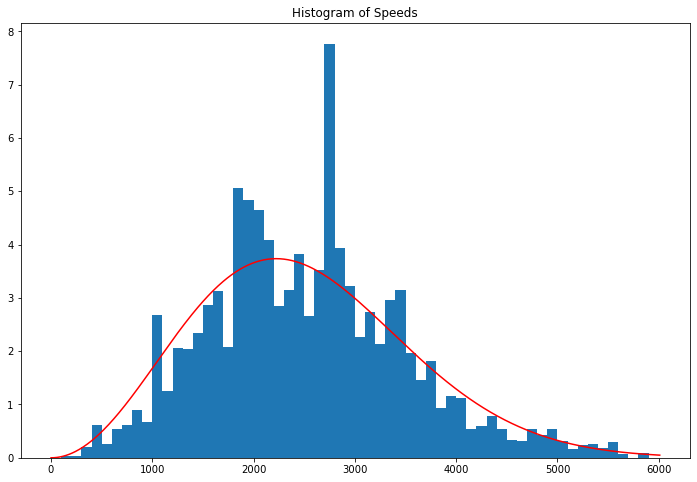

In [12]:
#plot histogram
#calculate speed at center of each bin
centers = [] #store speed at center of each bin
for i in range(len(binx)-1):
    vmiddle = (binx[i] + binx[i+1])/2 #calculate speed at center of bin
    centers.append(vmiddle)

## Add a theoretical plot
dv = 10
Ntheor = []
vtheory = []
for v in range(0,6001+dv,dv):
    Ntheor.append((deltav/dv)*N*4*pi*((m/(2*pi*k*T))**1.5) *exp(-0.5*m*(v**2)/(k*T))*(v**2)*dv ) # theoretical prediction
    vtheory.append(v)

#plot bar graph (histogram)
plt.figure(figsize=(12,8))
plt.bar(centers, histave, align='center', width=deltav)
plt.plot(vtheory,Ntheor,'r-')
plt.title('Histogram of Speeds')
plt.show()